In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:

#this section defines geometry
# an array of left co ordinates of each mesh is genrated and corresponding sigma arrays containing cross secitons are also generated
# this problem was taken from https://doi.org/10.1016/0306-4549(94)00091-R, known as 7 region heterogeneous slab, this particular code is the configuration with no absorber

fuel = 0
reflector = 1
absorber = 2
sigma_t_fra = np.array([0.415, 0.371, 0.371])
sigma_s_fra = np.array([0.334, 0.334, 0.037])
nu_sigmaf_fra = np.array([0.178, 0.0, 0.0])

mesh_divisions_per_region = 125
width_fra = np.array([1/sigma_t_fra[0], 1/sigma_t_fra[1], 1/ sigma_t_fra[2]]) # storing width for each region in MFP
mesh_fra = width_fra / mesh_divisions_per_region

sigma_t=np.empty(0)
sigma_s = np.empty(0)
nu_sigmaf = np.empty(0)
h_i = np.empty(0)

region = 0
x = 0
x_i =np.zeros(0)
cells_from_0 = 0
for region in range(7):

    if(region % 2 == 1 ):
        typ = fuel
    #elif(region==4):
    #    typ =  absorber
    else:
        typ = reflector

    x_region = np.arange(x, x+width_fra[typ]-mesh_fra[typ]/2, mesh_fra[typ]) #co ordinates of left endpoints each cell in fuel region
    x_i = np.append(x_i ,x_region )
    sigma_t = np.append(sigma_t,np.ones(len(x_region))*sigma_t_fra[typ])
    sigma_s = np.append(sigma_s,np.ones(len(x_region))*sigma_s_fra[typ])
    nu_sigmaf = np.append(nu_sigmaf,np.ones(len(x_region))*nu_sigmaf_fra[typ])
    h_i = np.append(h_i,np.ones(len(x_region))*mesh_fra[typ])
    x=x+width_fra[typ]

    

In [56]:
#tabuchi_yamamoto quadrature set
polar =3



sintheta_p = np.array([.166648, .537707, .932954])
theta_p = (np.arcsin(sintheta_p))
w_p = 2*(np.array([0.046233, 0.283619, 0.670148]))

mu_pplushalf = np.zeros(polar+1)

for i in range(polar+1):
    
    mu_pplushalf[i] = -1+sum(w_p[0:i])
#azimuthal angle 

azim = 256
w_b = 2*np.pi / azim
beta_b = np.arange(w_b/2,2*np.pi, w_b )

#exploiting symmetry
w_b = np.ones(azim)*w_b*2
azim = int(azim/2)



In [57]:
#transport sweep
def sweep_1d(q_i):
    I = len(x_i)
    alpha = 0 #vacuum at left
    psi_0 = 0 #no incident on right    
    #flux =  q_i/ sigma_t
    flux = np.zeros(I)
    del_psi = np.zeros((azim,polar))
    psi_boun = np.zeros((2,int(azim/2),polar))
    psi_avg = np.zeros((azim,polar))
    psi_in = np.zeros((azim,polar))
    #from left to right
    for i in range(I):
        
        for p in range(int(polar)):
            for b in range(int(azim/2)):
                
                length = abs(h_i[i]/(sintheta_p[p])/np.cos(beta_b[b]))
                del_psi[b,p] = (psi_in[b,p] - q_i[i]/(4*np.pi*sigma_t[i]))*(1-np.exp(-sigma_t[i]*length))
                psi_avg[b,p] = q_i[i]/(4*np.pi*sigma_t[i]) + del_psi[b,p]/(sigma_t[i]*length)
                flux[i] = flux[i] + w_b[b]*w_p[p]*psi_avg[b,p]
                
                #flux[i] = flux[i] + 1/(sigma_t[i]*length) * del_psi[b,p] *w_b[b]*w_p[p] 
                psi_in[b,p] = psi_in[b,p] - del_psi[b,p]
        
           
    psi_boun[0] = psi_in[0:int(azim/2)]
    psi_in[int(azim/2):azim, :] = alpha* np.flipud(psi_in[0:int(azim/2),:])
    #psi_in[int(azim/2):azim, :] = 0
    #print(psi_in)
    
    
    
    #right to left
    for i in reversed(range(I)):
        
        for p in range(polar):
            for b in range(int(azim/2),azim):
                length = abs(h_i[i]/(sintheta_p[p])/np.cos(beta_b[b]))
                del_psi[b,p] = (psi_in[b,p] - q_i[i]/(4*np.pi*sigma_t[i]))*(1-np.exp(-sigma_t[i]*length))
                psi_avg[b,p] = q_i[i]/(4*np.pi*sigma_t[i]) + del_psi[b,p]/(sigma_t[i]*length)
                flux[i] = flux[i] + w_b[b]*w_p[p]*psi_avg[b,p]
                #flux[i] = flux[i] + 1/(sigma_t[i]*length) * del_psi[b,p] *w_b[b]*w_p[p]
                psi_in[b,p] = psi_in[b,p] - del_psi[b,p]
    
    psi_boun[1] = psi_in[int(azim/2):azim]
    

    return flux,psi_boun

In [58]:
I=len(x_i)


def eigen_solver():
    keff_old = 1
    keff_new = 1

    psi_boun = np.zeros((2,int(azim/2),polar))
    psi_boun_new = np.zeros((2,int(azim/2),polar))
    psi_left = np.zeros((azim,polar))
    flux_old = np.ones(I) 
    flux_new = np.zeros(I)

    res_keff = np.inf
    res_flux= np.inf
    res_psi = np.inf

    fission_source_old = nu_sigmaf*flux_old
    fission_source_new = np.zeros(I)
    while(res_keff>10**-5):
        
        #print(q_i)
        res_flux = np.inf
        while(res_flux>10**-6 or res_psi>10**-6 ):
            q_i= fission_source_old/keff_old + sigma_s*flux_old
            flux_new , psi_boun_new= sweep_1d_homoslab(q_i)

            
            res_flux = max(abs((flux_new-flux_old)/flux_new))
            res_psi = np.amax(abs((psi_boun_new-psi_boun)/psi_boun_new))
            
            #print('flux error',res_flux, 'psi error :', res_psi)

            flux_old = flux_new
            
            psi_boun = psi_boun_new

        fission_source_new = nu_sigmaf * flux_new
        keff_new = keff_old* sum(fission_source_new*h_i)/sum(fission_source_old*h_i)

        res_keff = abs(keff_old-keff_new)
        keff_old = keff_new
        fission_source_old = fission_source_new
        print('eigenvalue=', keff_new, 'with error= ', res_keff)

        
    return keff_new, flux_new, psi_boun




eigenvalue= 1.1535185571919166 with error=  0.15351855719191665
eigenvalue= 1.1653382531701113 with error=  0.011819695978194655
eigenvalue= 1.1698336574599413 with error=  0.004495404289829974
eigenvalue= 1.1718268377565626 with error=  0.001993180296621322
eigenvalue= 1.172748584899364 with error=  0.0009217471428013546
eigenvalue= 1.1731798506399933 with error=  0.00043126574062934964
eigenvalue= 1.1733828468460668 with error=  0.00020299620607344693
eigenvalue= 1.1734772845657582 with error=  9.443771969142034e-05
eigenvalue= 1.1735217766105186 with error=  4.4492044760424676e-05
eigenvalue= 1.1735431664245706 with error=  2.1389814051975264e-05
eigenvalue= 1.1735538419939782 with error=  1.0675569407592178e-05
eigenvalue= 1.1735586478406488 with error=  4.805846670619118e-06


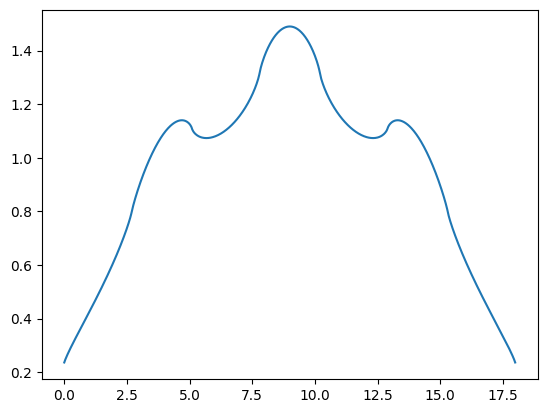

In [59]:
keff,flux_new, psi_boun = eigen_solver()

plt.plot(x_i, flux_new)
plt.show()